In [1]:
class Tokenizer():
    
    def __init__(self):
        self.word_index = {}
        self.index_word = {0: "<start>", 1: "<end>"}
        self.vocab_size = 2
        
        
    def fit(self, arr):
        self.word_index = {}
        self.index_word = {0: "<start>", 1: "<end>"}
        self.vocab_size = 2
        
        for word in arr:
            if word not in self.word_index:
                self.index_word[self.vocab_size] = word
                self.word_index[word] = self.vocab_size
                self.vocab_size += 1
                    
    def transform(self, sentence):
        return [0] + [self.word_index[word] for word in sentence] + [1]
    
    def reverse_transform(self, encoded_sentence):
        return [self.index_word[num] for num in encoded_sentence[1:-1]]

In [2]:
import os
from PIL import Image

import torch
from torch.utils.data import Dataset
from torchvision import transforms

class ImgCapDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df
        self.img_dir = img_dir
        self.image_transform = transforms.Compose([
                transforms.Resize((512, 512)),
                transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_1 = os.path.join(self.img_dir, self.df.iloc[idx]["Image1"] + ".png")
        img_1 = Image.open(img_1)
        img_1 = self.image_transform(img_1)
        
        img_2 = os.path.join(self.img_dir, self.df.iloc[idx]["Image2"] + ".png")
        img_2 = Image.open(img_2)
        img_2 = self.image_transform(img_2)
        
        caption = torch.LongTensor(self.df.iloc[idx]["CaptionSeq"])

        return img_1, img_2, caption

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg16

class CNN_Encoder(nn.Module):
    
    def __init__(self):
        super(CNN_Encoder, self).__init__()
        self.conv = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding='same')
        self.fc = nn.Linear(256*256*16, 128)

        self.conv2 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding='same')
        self.fc2 = nn.Linear(256*256*16, 128)

    def forward(self, x1, x2):
        x1 = F.relu(self.conv(x1))
        x1 = F.max_pool2d(x1, 2)
        x1 = torch.flatten(x1, 1)
        x1 = self.fc(x1)

        x2 = F.relu(self.conv2(x2))
        x2 = F.max_pool2d(x2, 2)
        x2 = torch.flatten(x2, 1)
        x2 = self.fc2(x2)

        return torch.cat((x1, x2), 1)
    
class VGG_Encoder(nn.Module):
    
    def __init__(self):
        super(VGG_Encoder, self).__init__()
        self.vgg1 = vgg16(pretrained=True)
        seq1 = list(self.vgg1.classifier)
        seq1[-1] = nn.Linear(4096, 1024, bias=True)
        seq1.append(nn.ReLU(inplace=True))
        seq1.append(nn.Dropout(p=0.5, inplace=False))
        seq1.append(nn.Linear(1024, 128, bias=True))
        self.vgg1.classifier = nn.Sequential(*seq1)
        
        for param in self.vgg1.features.parameters():
            param.requires_grad = False
        
        self.vgg2 = vgg16(pretrained=True)
        seq2 = list(self.vgg2.classifier)
        seq2[-1] = nn.Linear(4096, 1024, bias=True)
        seq2.append(nn.ReLU(inplace=True))
        seq2.append(nn.Dropout(p=0.5, inplace=False))
        seq2.append(nn.Linear(1024, 128, bias=True))
        self.vgg2.classifier = nn.Sequential(*seq2)
        
        for param in self.vgg2.features.parameters():
            param.requires_grad = False
        
    def forward(self, x1, x2):
        
        x1 = self.vgg1(x1)
        x2 = self.vgg2(x2)
        
        return torch.cat((x1, x2), 1)
        

class RNN_Decoder(nn.Module):

    def __init__(self, embed_size, hidden_size, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTMCell(embed_size, hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, caption):

        cap = torch.transpose(self.embed(caption), 0, 1)
        output = torch.empty((caption.size(0), caption.size(1), self.vocab_size))

        for i in range(caption.size(1)):

            if i == 0:
                device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                h = torch.autograd.Variable(torch.zeros(x.size(0), self.hidden_size)).to(device)
                c = torch.autograd.Variable(torch.zeros(x.size(0), self.hidden_size)).to(device)
                h, c = self.rnn(x, (h ,c))
            else:
                h, c = self.rnn(cap[i,:,:], (h, c))

            output[:,i,:] = self.fc(h)

        return output

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

class BaseModel():
    
    def __init__(self, df, image_address, sentence_length, vocab_size, epoch, encoder_name):
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.df = df.sample(frac=1).reset_index(drop=True)
        train_df, val_df = self.train_val_split(self.df)
        train_ds = ImgCapDataset(train_df, image_address)
        val_ds = ImgCapDataset(val_df, image_address)
        
        self.train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
        self.val_dl = DataLoader(val_ds, batch_size=16, shuffle=True)
        
        self.EPOCH = epoch
        
        if encoder_name == "CNN":
            self.encoder = CNN_Encoder()
        elif encoder_name == "VGG":
            self.encoder = VGG_Encoder()
        self.decoder = RNN_Decoder(256, sentence_length, vocab_size)
        
        self.encoder = self.encoder.to(device)
        self.decoder = self.decoder.to(device)
        
        self.encoder_optim = torch.optim.Adam(self.encoder.parameters(), 0.0001)
        self.decoder_optim = torch.optim.Adam(self.decoder.parameters(), 0.0001)
        self.LOSS = torch.nn.CrossEntropyLoss()
        
    def train_val_split(self, df):
        split = 4*len(df)//5
        train = df.iloc[:split,:]
        val = df.iloc[split:,:]
        return train, val
    
    def train(self):
        self._training_loop(
            self.EPOCH, self.encoder, self.decoder, self.encoder_optim, 
            self.decoder_optim, self.LOSS, self.train_dl, self.val_dl
        )
        
    def _training_loop(self, epochs, encoder, decoder, encoder_optimizer, decoder_optimizer, loss_f, train_loader, val_loader):
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        for epoch in range(epochs):
            loss_train = 0.0
            for x1, x2, y in train_loader:
                x1 = x1.to(device)
                x2 = x2.to(device)
                y = y.to(device)
                
                out = encoder(x1, x2)
                out = decoder(out, y)
                out = out.to(device)
                loss = loss_f(torch.flatten(out, 0, 1), torch.flatten(y))

                encoder_optimizer.zero_grad()
                decoder_optimizer.zero_grad()
                loss.backward()
                encoder_optimizer.step()
                decoder_optimizer.step()
                loss_train += loss.item()
                
            loss_val = 0.0
            for x1, x2, y in val_loader:
                x1 = x1.to(device)
                x2 = x2.to(device)
                y = y.to(device)
                
                out = encoder(x1, x2)
                out = decoder(out, y)
                out = out.to(device)
                loss = loss_f(torch.flatten(out, 0, 1), torch.flatten(y))
                loss_val += loss.item()
            print("Epoch", epoch, "Train Loss", loss_train/len(train_loader), "Validation Loss", loss_val/len(val_loader))
    
    def sample(self, tokenizer):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        x1, x2, c = next(iter(self.val_dl))
        x1 = x1.to(device)
        x2 = x2.to(device)
        c = c.to(device)
        out1 = self.encoder.forward(x1, x2)
        out2 = self.decoder.forward(out1, c)
        encoded_out = torch.argmax(out2, dim=2).cpu().detach().numpy()

        decoded_out = []
        for i in range(encoded_out.shape[0]):
            tmp = [tokenizer.index_word[x] for x in encoded_out[i] if x not in (0, 1)]
            decoded_out.append(" ".join(tmp))

        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(x1[0].permute(1, 2, 0).cpu().detach().numpy())
        ax[1].imshow(x2[0].permute(1, 2, 0).cpu().detach().numpy())
        plt.show()
        print(decoded_out[0])

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
from torch.utils.data import DataLoader
from torchtext.data.metrics import bleu_score

In [6]:
df = pd.read_csv("../input/imagecaption/data/processed.csv")
df = df[["Image1", "Image2", "Clean_capt"]]
df.columns = ["Image1", "Image2", "Caption"]
print(df.shape)
df.head()

(4017, 3)


,Image1,Image2,Caption
0,CXR162_IM-0401-1001,CXR162_IM-0401-2001,normal chest
1,CXR1390_IM-0249-1001,CXR1390_IM-0249-2001,no evidence active disease
2,CXR604_IM-2193-1001,CXR604_IM-2193-2001,no evidence active disease
3,CXR2699_IM-1167-1001,CXR2699_IM-1167-2001,no acute cardiopulmonary disease
4,CXR2841_IM-1253-2001,CXR2841_IM-1253-2001,no acute cardiopulmonary disease


In [7]:
tokenizer = Tokenizer()
tokenizer.fit(reduce(lambda a, b: a+b, df.Caption.str.split()))
cap = df.Caption.apply(lambda x: tokenizer.transform(x.split()))
cap_len = cap.apply(len).value_counts().sort_index()
cap_len

3       10
4      109
5      469
6     1443
7      292
      ... 
65       1
66       1
86       1
89       1
90       2
Name: Caption, Length: 63, dtype: int64

In [8]:
LENGTH = 64
seq_trim = cap_len[cap_len.index > LENGTH]
print("If trimmed by length %d, %d captions will be trimmed" % (LENGTH, seq_trim.sum()))
print("If trimmed by length %d, %.2f%% of captions will be trimmed" % (LENGTH, seq_trim.sum()*100/len(df)))

If trimmed by length 64, 6 captions will be trimmed
If trimmed by length 64, 0.15% of captions will be trimmed


In [9]:
df["CaptionSeq"] = cap.apply(lambda x: x + [1] * (LENGTH - len(x)) if len(x) < LENGTH else x[:LENGTH])
df.head()

,Image1,Image2,Caption,CaptionSeq
0,CXR162_IM-0401-1001,CXR162_IM-0401-2001,normal chest,"[0, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,CXR1390_IM-0249-1001,CXR1390_IM-0249-2001,no evidence active disease,"[0, 4, 5, 6, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,CXR604_IM-2193-1001,CXR604_IM-2193-2001,no evidence active disease,"[0, 4, 5, 6, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,CXR2699_IM-1167-1001,CXR2699_IM-1167-2001,no acute cardiopulmonary disease,"[0, 4, 8, 9, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,CXR2841_IM-1253-2001,CXR2841_IM-1253-2001,no acute cardiopulmonary disease,"[0, 4, 8, 9, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [10]:
cnn_model = BaseModel(df, "../input/imagecaption/data/images", LENGTH, tokenizer.vocab_size, 20, "CNN")
cnn_model.train()

Epoch 0 Train Loss 4.42494975156452 Validation Loss 2.1748702479343787
Epoch 1 Train Loss 1.4732235198590293 Validation Loss 1.1763492881083022
Epoch 2 Train Loss 1.0233246953926276 Validation Loss 0.9284669219278822
Epoch 3 Train Loss 0.8465292415215602 Validation Loss 0.7836705481304842
Epoch 4 Train Loss 0.7235757223705748 Validation Loss 0.6749890534316793
Epoch 5 Train Loss 0.6316463202979434 Validation Loss 0.5924276636511672
Epoch 6 Train Loss 0.5570589194250344 Validation Loss 0.5292496196195191
Epoch 7 Train Loss 0.4919349336579664 Validation Loss 0.46823110504477633
Epoch 8 Train Loss 0.4390870962125152 Validation Loss 0.42639972240317103
Epoch 9 Train Loss 0.39706987035066926 Validation Loss 0.39559826327889575
Epoch 10 Train Loss 0.3617950358719968 Validation Loss 0.356622861150433
Epoch 11 Train Loss 0.3310482744776194 Validation Loss 0.34158562255256314
Epoch 12 Train Loss 0.30466854896637335 Validation Loss 0.30660348370963453
Epoch 13 Train Loss 0.2816535181444676 Valid

In [10]:
model = BaseModel(df, "../input/imagecaption/data/images", LENGTH, tokenizer.vocab_size, 20, "VGG")
model.train()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Epoch 0 Train Loss 3.7744104174239124 Validation Loss 1.8777332025415756
Epoch 1 Train Loss 1.3795158720728178 Validation Loss 1.1393626414093316
Epoch 2 Train Loss 0.9747275990336689 Validation Loss 0.9063410016835904
Epoch 3 Train Loss 0.7956116813332287 Validation Loss 0.7551579679928574
Epoch 4 Train Loss 0.673200232620856 Validation Loss 0.6645983425425548
Epoch 5 Train Loss 0.589465688117108 Validation Loss 0.5911243926076328
Epoch 6 Train Loss 0.5240361230883432 Validation Loss 0.5212182469812094
Epoch 7 Train Loss 0.4705912043799215 Validation Loss 0.4738648951637979
Epoch 8 Train Loss 0.4250721017000687 Validation Loss 0.4443040671301823
Epoch 9 Train Loss 0.38676245373428164 Validation Loss 0.39111747578078626
Epoch 10 Train Loss 0.35424349260567434 Validation Loss 0.3613775129996094
Epoch 11 Train Loss 0.32591378679545363 Validation Loss 0.3446006409677805
Epoch 12 Train Loss 0.3008830268955349 Validation Loss 0.3172692416929731
Epoch 13 Train Loss 0.27862269199680334 Valida

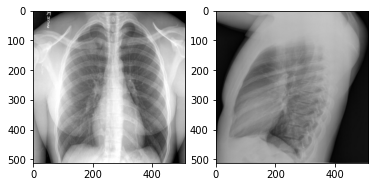

no acute abnormality


In [11]:
model.sample(tokenizer)